### CARTEIRA DE FUNDOS IMOBILIÁRIOS

In [19]:
import pandas as pd
import requests
import plotly.express as px
import plotly.graph_objects as go
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle
from reportlab.lib.utils import ImageReader
from matplotlib.colors import LinearSegmentedColormap
import io
from PyPDF2 import PdfMerger
import pdfkit


In [20]:
# Carregar o arquivo Excel
file_path = r'C:\Users\GuilhermeSCopetti\Desktop\Projetos Python + AI\Projeto2(Dash_FII)\Tabela_FII\Carteira_FII(SA).xlsx'
df = pd.read_excel(file_path)

In [21]:
df['FII'] = df['FII'].astype(str)
# Função para atualizar as cotações dos FII
def atualizar_cotacoes(df):
    tickers = df['FII'].tolist()
    cotacoes = {}
    
    for ticker in tickers:
        try:
            cotacao = yf.Ticker(ticker).history(period="1d")['Close'].iloc[0]
            cotacoes[ticker] = cotacao
        except (IndexError, KeyError, ValueError):
            cotacoes[ticker] = None
            
    df['P.Atual'] = df['FII'].map(cotacoes)
    return df

# Atualizar o DataFrame com as cotações atuais
df = atualizar_cotacoes(df)

# Preprocessar o DataFrame (remover NaN se necessário)
df_clean = df.dropna(subset=['FII', 'P.Atual'])

# Aplicar a função à coluna 'P.Atual' e calcular 'V.Atual'

df['V.Atual'] = df['qtd'] * df['P.Atual']

# Total: V.Atual
df.loc[12, 'V.Atual']=df['V.Atual'].sum()
df

,Peso,FII,Tipo de Fundo,Segmento,qtd,P.Entrada,Valor.Entrada,P.Atual,V.Atual
0,12.308988,BCFF11.SA,NaN,NaN,85.0,8.890000,755.65,8.260000,702.100019
1,10.611157,HSML11.SA,NaN,NaN,7.0,93.060000,651.42,95.360001,667.520004
2,20.177195,RECR11.SA,NaN,NaN,14.0,88.477143,1238.68,84.989998,1189.859970
3,7.599922,VISC11.SA,NaN,NaN,4.0,116.640000,466.56,112.949997,451.799988
4,2.961390,RBRR11.SA,NaN,NaN,2.0,90.900000,181.80,90.959999,181.919998
5,9.925053,BRCO11.SA,NaN,NaN,5.0,121.860000,609.30,116.910004,584.550018
6,7.451527,VGIP11.SA,NaN,NaN,5.0,91.490000,457.45,88.529999,442.649994
7,13.713938,CVBI11.SA,NaN,NaN,10.0,84.190000,841.90,93.500000,935.000000
8,1.908614,MALL11.SA,NaN,NaN,1.0,117.170000,117.17,108.269997,108.269997
9,1.676492,VILG11.SA,NaN,NaN,1.0,102.920000,102.92,88.959999,88.959999


In [22]:
# Criar variaveis para receber o somatório do Valor.Entrada e V.Atual
valor_Entrada=df.iloc[12, 6] 
valor_Atual=df.iloc[12, 8]


## Buscando Informações dos FII com método Webscraping 
- SEGMENTO (Ex: Shoppings / Varejo); TIPO DE FUNDO(Ex:Fundo de Tijolo)

In [23]:
# Carregar o arquivo Excel
file_path = r'C:\Users\GuilhermeSCopetti\Desktop\Projetos Python + AI\Projeto2(Dash_FII)\Tabela_FII\Carteira_FII.xlsx'
df_SA = pd.read_excel(file_path)
df_SA

,Peso,FII,Tipo de Fundo,Segmento,qtd,P.Entrada,Valor.Entrada,P.Atual,V.Atual
0,12.308988,BCFF11,NaN,NaN,85.0,8.890000,755.65,0.0,0
1,10.611157,HSML11,NaN,NaN,7.0,93.060000,651.42,0.0,0
2,20.177195,RECR11,NaN,NaN,14.0,88.477143,1238.68,0.0,0
3,7.599922,VISC11,NaN,NaN,4.0,116.640000,466.56,0.0,0
4,2.961390,RBRR11,NaN,NaN,2.0,90.900000,181.80,0.0,0
5,9.925053,BRCO11,NaN,NaN,5.0,121.860000,609.30,0.0,0
6,7.451527,VGIP11,NaN,NaN,5.0,91.490000,457.45,0.0,0
7,13.713938,CVBI11,NaN,NaN,10.0,84.190000,841.90,0.0,0
8,1.908614,MALL11,NaN,NaN,1.0,117.170000,117.17,0.0,0
9,1.676492,VILG11,NaN,NaN,1.0,102.920000,102.92,0.0,0


In [24]:
df_SA['FII']
lista_fii = df_SA['FII'].tolist()

def scraping_uf(uf: str):
    uf_url = f'https://investidor10.com.br/fiis/{uf}/'
    browsers = {'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.198 Safari/537.36"}
    page = requests.get(uf_url, headers=browsers)
    
    soup = BeautifulSoup(page.content, 'html.parser')
    table = soup.select_one('#table-indicators')
    
    uf_dict = {}
    if table:
        cells = table.select('div.cell')
        for cell in cells:
            name = cell.select_one('.name').text.strip()
            value = cell.select_one('.value span').text.strip()
            uf_dict[name] = value

    return uf_dict


In [25]:
# Verificar se a coluna 'FII' está presente no DataFrame
if 'FII' not in df.columns:
    raise ValueError("A coluna 'FII' não está presente no DataFrame")

# Criação de uma lista para armazenar os dados dos FIIs
fii_data_list = []

In [26]:
# Loop para fazer scraping de cada FII e adicionar à lista
for fii_ticker in df_SA['FII']:
    fii_info = scraping_uf(fii_ticker)
    fii_info['FII'] = fii_ticker
    fii_data_list.append(fii_info)

# Converter a lista de dicionários em um DataFrame
fii_data = pd.DataFrame(fii_data_list)

In [27]:
# Incluir fii_data['TIPO DE FUNDO'] e fii_data['SEGMENTO'] no dataframe(Tabela Cripto)
df['Tipo de Fundo'] = fii_data['TIPO DE FUNDO']
df['Segmento'] = fii_data['SEGMENTO']


In [28]:
#Retirar .SA e incluir no dataframe(Carteira_FIIs)
lista_fii = df['FII'].tolist()
lista_sem_SA = [item.replace('.SA', '') for item in lista_fii]
df['FII']=lista_sem_SA 

In [29]:
# Formatando a tabela para retornar 2 casas decimais
df['Peso'] = df['Peso'].round(2)
df['qtd'] = df['qtd'].round(2)
df['P.Entrada'] = df['P.Entrada'].round(2)
df['Valor.Entrada'] = df['Valor.Entrada'].round(2)
df['P.Atual'] = df['P.Atual'].round(2)
df['V.Atual'] = df['V.Atual'].round(2)

df_clean = df.dropna(subset=['FII', 'P.Atual'])

labels = df_clean['FII']
values = df_clean['P.Atual']

del df['Peso']
#del df['Segmento']
df = df.iloc[:-1]

fii_tipo_de_fundo=df
fii_tipo_de_fundo

,FII,Tipo de Fundo,Segmento,qtd,P.Entrada,Valor.Entrada,P.Atual,V.Atual
0,BCFF11,Fundo de fundos,Títulos e Valores Mobiliários,85.0,8.89,755.65,8.26,702.10
1,HSML11,Fundo de Tijolo,Shoppings / Varejo,7.0,93.06,651.42,95.36,667.52
2,RECR11,Fundo de papel,Títulos e Valores Mobiliários,14.0,88.48,1238.68,84.99,1189.86
3,VISC11,Fundo de Tijolo,Shoppings / Varejo,4.0,116.64,466.56,112.95,451.80
4,RBRR11,Fundo de papel,Títulos e Valores Mobiliários,2.0,90.90,181.80,90.96,181.92
5,BRCO11,Fundo de Tijolo,Logístico / Indústria / Galpões,5.0,121.86,609.30,116.91,584.55
6,VGIP11,Fundo de papel,Títulos e Valores Mobiliários,5.0,91.49,457.45,88.53,442.65
7,CVBI11,Fundo de papel,Títulos e Valores Mobiliários,10.0,84.19,841.90,93.50,935.00
8,MALL11,Fundo de Tijolo,Shoppings / Varejo,1.0,117.17,117.17,108.27,108.27
9,VILG11,Fundo de Tijolo,Logístico / Indústria / Galpões,1.0,102.92,102.92,88.96,88.96


### Criar Gráfico dos pesos Valor Entrada e Valor Atual

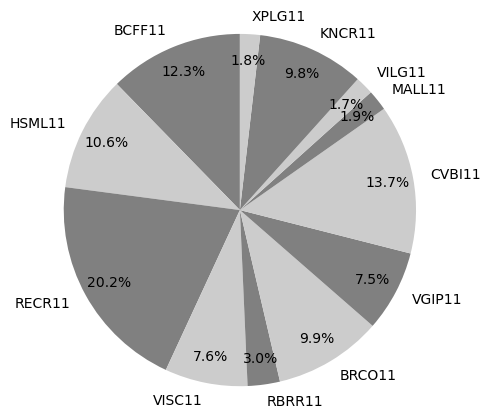

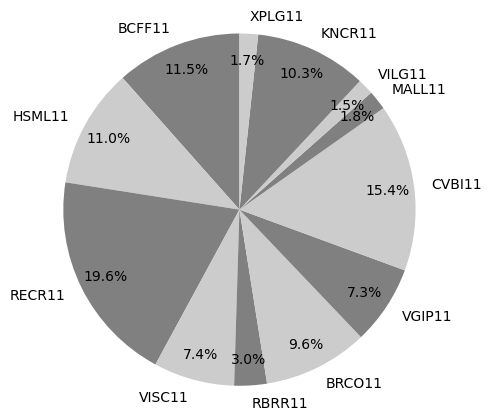

In [30]:
# Data processing
fii_tipo_de_fundo_clean = fii_tipo_de_fundo.dropna(subset=['FII', 'Valor.Entrada'])
labels = fii_tipo_de_fundo_clean['FII']
sizes = fii_tipo_de_fundo_clean['Valor.Entrada']
# Data processing for the second pie chart
fii_tipo_de_fundo_clean_v_atual = fii_tipo_de_fundo.dropna(subset=['FII', 'V.Atual'])
labels_v_atual = fii_tipo_de_fundo_clean_v_atual['FII']
sizes_v_atual = fii_tipo_de_fundo_clean_v_atual['V.Atual']


# Defina uma paleta de cores em escala de cinza
gray_cmap = LinearSegmentedColormap.from_list('gray', ['#000000', '#FFFFFF'])

# Crie o gráfico de pizza com a paleta de cores em escala de cinza
fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=[gray_cmap(0.5), gray_cmap(0.8)], pctdistance=0.85)
ax.axis('equal')  # Proporção igual garante que o gráfico seja desenhado como um círculo

# Save the pie chart as a PNG file
plt.savefig('grafico_pizza.png')

# Create the second pie chart
fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(sizes_v_atual, labels=labels_v_atual, autopct='%1.1f%%', startangle=90, colors=[gray_cmap(0.5), gray_cmap(0.8)], pctdistance=0.85)
ax.axis('equal')  # Equal aspect ratio ensures that the chart is drawn as a circle

# Save the second pie chart as a PNG file
plt.savefig('grafico_pizza_v_atual.png')

In [32]:
# Acrescentar R$ ao Valores da tabela
df.loc[:, 'P.Entrada'] = 'R$' + df['P.Entrada'].astype(str)
df.loc[:, 'Valor.Entrada'] = 'R$' + df['Valor.Entrada'].astype(str)
df.loc[:, 'P.Atual'] = 'R$' + df['P.Atual'].astype(str)
df.loc[:, 'V.Atual'] = 'R$' + df['V.Atual'].astype(str)
df

,FII,Tipo de Fundo,Segmento,qtd,P.Entrada,Valor.Entrada,P.Atual,V.Atual
0,BCFF11,Fundo de fundos,Títulos e Valores Mobiliários,85.0,R$8.89,R$755.65,R$8.26,R$702.1
1,HSML11,Fundo de Tijolo,Shoppings / Varejo,7.0,R$93.06,R$651.42,R$95.36,R$667.52
2,RECR11,Fundo de papel,Títulos e Valores Mobiliários,14.0,R$88.48,R$1238.68,R$84.99,R$1189.86
3,VISC11,Fundo de Tijolo,Shoppings / Varejo,4.0,R$116.64,R$466.56,R$112.95,R$451.8
4,RBRR11,Fundo de papel,Títulos e Valores Mobiliários,2.0,R$90.9,R$181.8,R$90.96,R$181.92
5,BRCO11,Fundo de Tijolo,Logístico / Indústria / Galpões,5.0,R$121.86,R$609.3,R$116.91,R$584.55
6,VGIP11,Fundo de papel,Títulos e Valores Mobiliários,5.0,R$91.49,R$457.45,R$88.53,R$442.65
7,CVBI11,Fundo de papel,Títulos e Valores Mobiliários,10.0,R$84.19,R$841.9,R$93.5,R$935.0
8,MALL11,Fundo de Tijolo,Shoppings / Varejo,1.0,R$117.17,R$117.17,R$108.27,R$108.27
9,VILG11,Fundo de Tijolo,Logístico / Indústria / Galpões,1.0,R$102.92,R$102.92,R$88.96,R$88.96


 ## Tabela de Dividend Yield

In [35]:
# Selecionar somente as colunas:'FII' e 'ÚLTIMO RENDIMENTO'
df_DY = df
cols = ['FII', 'qtd']
df_DY = df_DY[cols]

# Reordenar as colunas colocando 'FII' na primeira posição e selecionar somente as colunas:'FII', 'ÚLTIMO RENDIMENTO'
cols = ['FII', 'ÚLTIMO RENDIMENTO']
fii_data = fii_data[cols]

#Juntar os dois dataframes
DY = pd.merge(df_DY, fii_data, on='FII')

# Remove o símbolo "R$" e converte para float
DY['ÚLTIMO RENDIMENTO'] = DY['ÚLTIMO RENDIMENTO'].str.replace('R$ ', '').str.replace(',', '.').astype(float)
# Criar uma nova coluna com o valor total de cada rendimento mensal de FII
DY['DY P/ FII'] = DY['qtd']*DY['ÚLTIMO RENDIMENTO'] 

#Calcular o somatorio dos DY
X = DY['DY P/ FII'].sum()

# Formatando a tabela para retornar 2 casas decimais
DY['DY P/ FII'] = DY['DY P/ FII'].round(2)
DY['ÚLTIMO RENDIMENTO'] = 'R$' + DY['ÚLTIMO RENDIMENTO'].astype(str)
DY['DY P/ FII'] = 'R$' + DY['DY P/ FII'].astype(str)

DY

,FII,qtd,ÚLTIMO RENDIMENTO,DY P/ FII
0,BCFF11,85.0,R$0.07,R$5.95
1,HSML11,7.0,R$0.8,R$5.6
2,RECR11,14.0,R$0.85,R$11.9
3,VISC11,4.0,R$0.85,R$3.4
4,RBRR11,2.0,R$0.85,R$1.7
5,BRCO11,5.0,R$0.87,R$4.35
6,VGIP11,5.0,R$0.88,R$4.4
7,CVBI11,10.0,R$0.97,R$9.7
8,MALL11,1.0,R$0.8,R$0.8
9,VILG11,1.0,R$0.65,R$0.65


### Criar Tabela para Somatório dos Valores Entrada, Valor Atual e DY Mensal

In [36]:
Rend_Carteria = pd.DataFrame({"valor Entrada":[valor_Entrada], "Valor Atual":[valor_Atual], "DY Mensal":[X]})
Rend_Carteria['valor Entrada'] = 'R$' + Rend_Carteria['valor Entrada'].round(2).astype(str)
Rend_Carteria['Valor Atual'] = 'R$' + Rend_Carteria['Valor Atual'].round(2).astype(str)
Rend_Carteria['DY Mensal'] = 'R$' + Rend_Carteria['DY Mensal'].round(2).astype(str)
Rend_Carteria

,valor Entrada,Valor Atual,DY Mensal
0,R$6139.01,R$6081.19,R$54.93


### Atualização de Carteira Semanal
Criar relatorio em PDF da atualização da carteira de FII 

In [38]:
from datetime import datetime

# Create a PDF file including both the table data and the pie chart
output_pdf = "Carteira_fii.pdf"

c = canvas.Canvas(output_pdf, pagesize=letter)
width, height = letter

# Obtendo a data atual
data_atual = datetime.now().strftime("%d/%m/%Y")

# Posição da data (acima e à esquerda)
c.drawString(30, height - 30, data_atual)

# Add the document title
c.drawCentredString(width / 2, height - 40, "Carteira de Fundos Imobiliários")

# Add table data
#c.drawString(100, height - 100, fii_data1)

# Add another section title
#c.drawCentredString(width / 2, height - 330, "Carteira de FII")

# Add another piece of information
#c.drawString(100, height - 160, fii_tipo_de_fundo1)

# Ajustando a posição do t para criar um espaço entre as tabelas
t2 = Table([df.columns.tolist()] + df.values.tolist())
t2.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('FONTSIZE', (0, 0), (-1, 0), 12),
    ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
    ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
    ('GRID', (0, 0), (-1, -1), 1, colors.black),
]))
table_width2, table_height2 = t2.wrapOn(c, width, height)
t2.drawOn(c, (width - table_width2) / 2, height - 50 - table_height2)  # Ajustar espaçamento para caber napágina 
#e espaço de 3cm entre tabelas

# tabela DY
# Ajustando a posição do t para criar um espaço entre as tabelas
t3 = Table([DY.columns.tolist()] + DY.values.tolist())
t3.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('FONTSIZE', (0, 0), (-1, 0), 12),
    ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
    ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
    ('GRID', (0, 0), (-1, -1), 1, colors.black),
]))


# Definindo a margem à esquerda
margem_esquerda = 30  # Você pode alterar esse valor para ajustar a distância da margem esquerda

# Cálculo das dimensões e posicionamento da tabela
table_width3, table_height3 = t3.wrapOn(c, width, height)

# Posicionando a tabela com base na margem esquerda
t3.drawOn(c, margem_esquerda, height - 540 - table_height3)

# tabela DY_Mensal 
# Ajustando a posição do t para criar um espaço entre as tabelas
t4 = Table([Rend_Carteria.columns.tolist()] + Rend_Carteria.values.tolist())
t4.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('FONTSIZE', (0, 0), (-1, 0), 12),
    ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
    ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
    ('GRID', (0, 0), (-1, -1), 1, colors.black),
]))


# Definindo a margem à esquerda
margem_direita = 350  # Você pode alterar esse valor para ajustar a distância da margem esquerda

# Cálculo das dimensões e posicionamento da tabela
table_width4, table_height4 = t4.wrapOn(c, width, height)

# Posicionando a tabela com base na margem esquerda
t4.drawOn(c, margem_direita, height - 540 - table_height3)

# Título acima do grafico grafico_pizza.png
c.drawString((width / 2) - 165, height - 25 - table_height2 - table_height2, "Peso Entrada") 

c.drawImage('grafico_pizza.png', (width / 4) - 80, height - 15 - table_height2 - table_height2, width=200, 
            height=200)  # Ajustar os gráficos abaixo da tabela fii_tipo_de_fundo

# Título acima do grafico grafico_pizza_v_atual.png
c.drawString((3 * width / 4) - 5, height - 25 - table_height2 - table_height2, "Peso Atual")  

c.drawImage('grafico_pizza_v_atual.png', (3*width / 4) - 80, height - 15 - table_height2 - table_height2, 
            width=200, height=200)  # Ajustar os gráficos abaixo da tabela fii_tipo_de_fundo

# Save the PDF
c.showPage()
c.save()

print("Arquivo PDF criado com sucesso!")
print(data_atual)

Arquivo PDF criado com sucesso!
18/08/2024


### Enviar E-Mail
- Email cadastrado para envio automático do Relatório da carteira de FII

In [40]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from dotenv import load_dotenv
import os

output_pdf = "Carteira_fii.pdf"

# Configurar as credenciais de e-mail
remetente = "Meu_Email@hotmail.com"
senha = os.getenv("EMAIL_SENHA")  # Acessa a senha armazenada na variável de ambiente
destinatario = "Destinatário@hotmail.com"

# 3. Configurando o e-mail
mensagem = MIMEMultipart()
mensagem['From'] = remetente
mensagem['To'] = destinatario
mensagem['Subject'] = "Cartira de FII Atualizada"

# Corpo do e-mail
corpo = "Cartira de FII Atualizada"
mensagem.attach(MIMEText(corpo, 'plain'))

# 4. Anexando o PDF ao e-mail
with open(output_pdf, "rb") as anexo:
    mime_base = MIMEBase('application', 'octet-stream')
    mime_base.set_payload(anexo.read())
    encoders.encode_base64(mime_base)
    mime_base.add_header('Content-Disposition', f'attachment; filename={os.path.basename(output_pdf)}')
    mensagem.attach(mime_base)

# 5. Enviando o e-mail
try:
    servidor = smtplib.SMTP('smtp.office365.com', 587)  # Servidor SMTP para Hotmail/Outlook
    servidor.starttls()
    servidor.login(remetente, senha)
    texto = mensagem.as_string()
    servidor.sendmail(remetente, destinatario, texto)
    servidor.quit()
    print("E-mail enviado com sucesso!")
except Exception as e:
    print(f"Erro ao enviar e-mail: {e}")


# Opcional: Excluir o PDF após envio
os.remove(output_pdf)


E-mail enviado com sucesso!
